We now have two metagenomic libraries created using illumina and 454.  First things first is to explore what these libraries look like:

In [8]:
from Bio import SeqIO
from Bio.SeqIO.QualityIO import PairedFastaQualIterator
#from scgcpy.utils import file_transaction

In [9]:
# merging qual and seq files:

fas = "../data/GZFH.454TrimmedReads.fna"
qual = "../data/GZFH.454TrimmedReads.qual"
outfile = "../data/GZFH_454.fastq"

In [11]:
def fasqual_to_fastq(fas, qual, outfile):
    #with file_transaction(outfile) as tx_out:
        tx_out = outfile
        with open(fas) as fin, open(qual) as qin, open(tx_out, "w") as oh:
            for i, rec in enumerate(PairedFastaQualIterator(fin, qin)):
                SeqIO.write(rec, oh, "fastq")
                if i == 10:
                    break
        return outfile

In [12]:
fasqual_to_fastq(fas, qual, outfile)

'../data/GZFH_454.fastq'

In [13]:
!open ../data/GZFH_454.fastq -a textedit

That worked... now expanded it to the entire fasta and qual files on charlie.

## Next running fragment recruitment using bwa and bbmap
* editing rcov.py to output more than just labelled contigs
* all this is going on charlie

```
mg1=./Test_FragRecruitment/Sakinaw/Hallam_metagenomes/2079.6.1746.fastq.gz 
mg2=./Test_FragRecruitment/Sakinaw/Hallam_metagenomes/GZFH_454.fastq.gz
gnms=./Test_FragRecruitment/Sakinaw/Hallam_SAGs_AAA255/Masked_genomes_AAA255/testfirst/
outdir=./fragdev/20160525/
```
this run was still running at the end of the day in a screen session
```
python ~/scripts/mp_recruit.py jrmr --fq1 ../Test_FragRecruitment/Sakinaw/Hallam_metagenomes/2079.6.1746.fastq.gz \
--outdir 20160525 --refdir ../Test_FragRecruitment/Sakinaw/Hallam_SAGs_AAA255/Masked_genomes_AAA255/testfirst/ \
--join --len_filter 150 &> 0525_jrmr2.log
```
this run finished:
```
python ~/scripts/mp_recruit.py jrmr --fq1 ../Test_FragRecruitment/Sakinaw/Hallam_metagenomes/GZFH_454.fastq.gz \
--outdir 20160525 --refdir ../Test_FragRecruitment/Sakinaw/Hallam_SAGs_AAA255/Masked_genomes_AAA255/testfirst/ \
--len_filter 150 &> 0525_jrmr3.log
```

re-run with max len set, and fasta file input:

```
mg2lenfilt=/mnt/stepanauskas_nfs/julia/Test_FragRecruitment/Sakinaw/Hallam_metagenomes/GZFH_454_gt150.fastq.gz
mg2fasta=/mnt/stepanauskas_nfs/julia/Test_FragRecruitment/Sakinaw/Hallam_metagenomes/GZFH_454TrimmedReads.fasta

python ~/scripts/mp_recruit.py jrmr --fq1 $mg2fasta --outdir ./20160525 \
--refdir ../Test_FragRecruitment/Sakinaw/Hallam_SAGs_AAA255/Masked_genomes_AAA255/testfirst/ \
--max_len 600 &> 0525_jrmr4.log
```

more variables:
```
log=0525_rcov1.log
outdir=./fragdev/20160525/
mg2lenfilt=/mnt/stepanauskas_nfs/julia/Test_FragRecruitment/Sakinaw/Hallam_metagenomes/GZFH_454_gt150.fastq.gz
```
running this at the end of the day in a screen session
```
parallel --retries 1 --bar --load 70% --joblog $log --jobs 3 python ~/scripts/rcov2.py \
print_cov --fastq $mg2lenfilt --reference {1} --outdir $outdir :::: firstlist.txt
```

And then this for the illumina library bwa:

```
mg1curated=/mnt/stepanauskas_nfs/julia/fragdev/20160525/2079.6.1746_gt150.fastq.extendedFrags_gt150.fastq.gz
log=0526_rcov2.log
parallel --retries 1 --bar --load 70% --joblog $log --jobs 3 python ~/scripts/rcov2.py \
print_cov --fastq $mg1curated --reference {1} --outdir $outdir :::: firstlist.txt
```

Now that these are all done and the scripts have been hashed out (a bit), a look at prelminary results:

In [53]:
import pandas as pd
from Bio import SeqIO
import gzip
import os.path as op
from collections import defaultdict
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [87]:
from __future__ import print_function
from __future__ import division

In [ ]:
def plot_read_size(fastq):
    gzopen=lambda i: gzip.open(i) if i.endswith(".gz") else open(i)
    with gzopen(fastq) as handle:
        for i, record in enumerate(SeqIO.parse(handle, "fastq")):
            readsizes[len(record.seq)] += 1
            readcount += 1
    hist = pd.DataFrame.from_dict(readsizes, orient='index')
    hist['length']=hist.index
    hist['read_count']=hist[0]
    fig = plt.plot(hist['length'], hist['read_count'], color='b')
    plt.ylabel('# reads')
    plt.xlabel('read length')
    name = op.dir(fastq)+"_".join(op.basename(fastq).split(".")[:-1])+.png

In [64]:
readsizes = defaultdict(lambda:0)
readcount = 0
with gzip.open("../data/i454comp/GZFH_454_gt150.fastq.gz", "rU") as handle:
    for i, record in enumerate(SeqIO.parse(handle, "fastq")):
        readsizes[len(record.seq)] += 1
        readcount += 1

    hist = pd.DataFrame.from_dict(readsizes, orient='index')
    
   

In [65]:
hist = pd.DataFrame.from_dict(readsizes, orient='index')
hist.index
readcount

554957

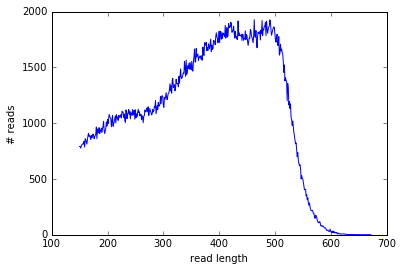

In [27]:
hist['length']=hist.index
hist['read_count']=hist[0]
hist
fig = plt.plot(hist['length'], hist['read_count'], color='b')
plt.ylabel('# reads')
plt.xlabel('read length')

In [29]:
gc1 = "../data/i454comp/GZFH_454_gt150_fastq_vs_AAA255A6_96912.genomecoverage"
gc2 = "../data/i454comp/GZFH_454_gt150_fastq_vs_AAA255B16_97682.genomecoverage"
gc3 = "../data/i454comp/GZFH_454_gt150_fastq_vs_AAA255C20_98068.genomecoverage"

In [57]:
gcov = gc1

coverage = pd.read_csv(gcov, sep="\t", header=None)
mean_per_contig = coverage.groupby([0])[2].mean() #.to_dict()
sum_per_contig = coverage.groupby([0])[2].sum() #.to_dict()
contig_size = coverage.groupby([0])[1].max()+1

In [58]:
mean_sag_coverage = mean_per_contig.mean()
mean_sag_coverage

2.973208857228565

In [59]:
totalbp = contig_size.sum()
uncovered_bp = sum(coverage[2]==0)
pct_covered = (totalbp - uncovered_bp)/totalbp * 100
pct_covered

100

In [60]:
total_scaffold = len(sum_per_contig)
uncovered_contig = sum(sum_per_contig==0)
pct_scaffolds_covered = (total_scaffold - uncovered_contig)/total_scaffold *100

In [61]:
pct_scaffolds_covered

100

In [63]:
sag = op.basename(gcov).split("_vs_")[1].strip(".genomecoverage")
sag

'AAA255A6_96912'

In [105]:
idx = ['Percent_scaffolds_with_any_coverage', 'Percent_of_reference_bases_covered', 'Average_coverage']
d = {sag: [pct_scaffolds_covered, pct_covered, mean_sag_coverage]}

In [106]:
df = pd.DataFrame(data=d, index=idx)

In [107]:
df

,AAA255A6_96912
Percent_scaffolds_with_any_coverage,100.000000
Percent_of_reference_bases_covered,100.000000
Average_coverage,2.973209


In [90]:
test_md = '103^T53C2T341'

In [91]:
def _match_len(md):
    length=0
    mismatch=0
    number=""
    for i, c in enumerate(md):
        try:
            val = int(c)
            number = number+c
        except:
            if len(number) > 0:
                length += int(number)
                number=""
        if i == len(md)-1:
            length += int(number)
    return length

In [93]:
assert _match_len(test_md) == 499

In [ ]:
md = str(b).split("\t")[-1].split(",")[3].replace(")","").replace("'","").strip()  #get md value from raw sam/bam entry

In [ ]:
import pysam

def filter_bam(bam, outbam, pctid = 95):
    with pysam.AlignmentFile(bam, "rb") as ih, pysam.AlignmentFile(outbam, "wb", template=ih) as oh:
        good = 0
        total = 0
        for i, l in enumerate(ih):
            if l.is_duplicate:
                continue

            total += 1
            md = str(l).split("\t")[-1].split(",")[3].replace(")","").replace("'","").strip()  #get md value from raw bam entry
            match = match_len(md)
            pct_match = (match)/l.rlen * 100

            if pct_match > pctid:
                good += 1
                oh.write(l)
        print("there were %s good read alignments out of %s total alignments" % (good, total))